# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [106]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [108]:
import pandas as pd
import numpy as np
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)

# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2020,1,1,0,0,0),
                                    '$lt': datetime.datetime(2020,1,31,0,0,0)},
            'retweeted_id': None
            })
        ))# Load the regular expression library
pd.set_option('display.max_colwidth', 0)

import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

sample_df = time_sample_df
# Remove punctuation
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text')].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('http.*', '', x))

sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
sample_df['full_text_processed'].head(200)

sample_df = sample_df[sample_df['full_text_processed'] != '']
sample_df = sample_df[sample_df['full_text_processed'] != ' ']



0      BargelderhaltenAfD                                                                                                                                                                                                           
1      +++Neue Klartext Hier runterladen+++                                                                                                                                                                                         
2      entglast welcher Redakteur ist für sowas verantwortlich🙄                                                                                                                                                                     
3      Obergrenze🤔                                                                                                                                                                                                                  
4      Hab ich schon vor ein paar Tagen gesagtAfDwirkt sogar bei BILD nurnochAfD    

In [186]:
date = []
for timestamp in sample_df.created_at_datetime:
    date.append(timestamp.date())
      
sample_df.loc[:, ('date')] = date
sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
# mdp_tweets.loc[:,('week')] = mdp_tweets.created_at_datetime.dt.weekofyear
sample_df.loc[:,('week')] = sample_df.created_at_datetime.dt.strftime('%y-w%V')

In [109]:
sample_mdp = np.array(sample_df['full_text_processed'])

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

import pickle, gensim, numpy as np

from utilities import get_train_data, get_test_data, Tokenizer, find_subtoken

PICKLE_FOLDER_PATH = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/'

TRAIN_FILENAME = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/germeval2018.training.txt'
#mdp = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/mdp_tweets.txt'

#------------------------------
#source:
#http://www.cl.uni-heidelberg.de/english/research/downloads/resource_pages/GermanTwitterEmbeddings/GermanTwitterEmbeddings_data.shtml
MODEL_FILENAME  = "/home/lisa/Darmstadt/Master Arbeit/06_Analyse/twitter-de_d100_w5_min10.bin" # 821,8 MB
MODEL_DIMENSION = 100

In [111]:
%%time
word2vec_model  = gensim.models.KeyedVectors.load_word2vec_format(MODEL_FILENAME, binary=True)

X_train, y_train_t1, y_train_t2 = get_train_data(TRAIN_FILENAME)
X_test_mdp                      = sample_mdp

X_test_mdp = X_test_mdp[X_test_mdp != '']
X_test_mdp = X_test_mdp[X_test_mdp != ' ']

CPU times: user 10.1 s, sys: 726 ms, total: 10.8 s
Wall time: 10.8 s


### NGRAM FEATURES
 * Erstelle n-Gramme mit 3-7 Buchstaben (Funktion: char_vect)
 * Erstelle n-Gramme mit 1-3 Wörtern /Funkion: token_vect
 * Anwendung auf Training/ Test und mdp Daten

In [112]:
char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3, 7), max_df=0.01, min_df=0.0002,
                             preprocessor=Tokenizer(preserve_case=False, join=True).tokenize)

token_vect = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), max_df=0.01, min_df=0.0002,
                             tokenizer=Tokenizer(preserve_case=False, use_stemmer=True).tokenize)

X_CNGR_train = char_vect.fit_transform(X_train)
X_CNGR_mdp = char_vect.transform(X_test_mdp)

X_TNGR_train = token_vect.fit_transform(X_train)
X_TNGR_mdp  = token_vect.transform(X_test_mdp)

In [113]:
# pickle.dump(X_CNGR_train, open(PICKLE_FOLDER_PATH + "X_CNGR_train.p", "wb" ))
pickle.dump(X_CNGR_mdp,  open(PICKLE_FOLDER_PATH + "X_CNGR_mdp.p", "wb" ))

# pickle.dump(X_TNGR_train, open(PICKLE_FOLDER_PATH + "X_TNGR_train.p", "wb" ))
pickle.dump(X_TNGR_mdp, open(PICKLE_FOLDER_PATH + "X_TNGR_mdp.p", "wb" ))

In [120]:
print(X_CNGR_mdp.shape) # (9958, 207575)

(14897, 207575)


### EMB FEATURES
* Tweets werden in Token unterteilt
* Prüfe ob die Token in einem Token im vortrainierten word2vec Model entsprechen
* Wenn nicht, teile Token in Präfix und Suffix und prüfe für diese das word2vec Model (ggf. beide in emb)
* emb enthält pro Tweet Vektoren für Token und wird normalisiert mit der Länge des Tweets + ggf extra Tokens
* X_EMB enthält die normalisierten Vektoren pro Tweet

In [114]:
def get_EMB_feats(tweets):   
    tknzr = Tokenizer(preserve_case=True)
    tweets = [tknzr.tokenize(tweet) for tweet in tweets]
    
    X_EMB = []

    for tweet in tweets:
        emb = np.zeros(MODEL_DIMENSION)
        extra_tokens = 0
        
        for token in tweet:
            try:
                emb += word2vec_model[token]
            except:
                prefix = find_subtoken(token, word2vec_model, mode='initial')
                suffix = find_subtoken(token, word2vec_model, mode='final')
                    
                if prefix != None and suffix != None:
                    emb += word2vec_model[prefix] + word2vec_model[suffix]
                    extra_tokens += 1
                elif prefix != None and suffix == None:
                    emb += word2vec_model[prefix]
                elif prefix == None and suffix != None:
                    emb += word2vec_model[suffix]           
        emb /= (len(tweet) + extra_tokens)
        X_EMB.append(emb)
        
    return normalize(X_EMB)

In [115]:
%%time
X_EMB_train = get_EMB_feats(X_train)
X_EMB_mdp  = get_EMB_feats(X_test_mdp)

CPU times: user 3.41 s, sys: 79.8 ms, total: 3.49 s
Wall time: 3.41 s


In [118]:
print(X_EMB_mdp.shape)

(14897, 100)


In [119]:
pickle.dump(X_EMB_train, open(PICKLE_FOLDER_PATH + "X_EMB_train.p", "wb" ))
pickle.dump(X_EMB_mdp,  open(PICKLE_FOLDER_PATH + "X_EMB_mdp.p", "wb" ))

### TIMP FEATURES
* Finden der wichtigen Tokens - also derer die in Tweets der angegebenen Kategorie verwendet werden
* Für diese wichtigsten Tokens werden die Features analog der EMB Features aus dem word2vec model abgeleitet
* Außerdem werden für alle Tweets analog der EMB feats abgeleitet
* Vergleiche mit der Cosine Similarity und gebe die höchsten und niedrigsten Werte pro Tweet zurück


In [122]:
def k_most_imp_tokenlvl(k, category, max_df=0.01, min_df=0.0002):      
    token_vect = TfidfVectorizer(analyzer="word", ngram_range=(1, 1), lowercase=False,
                                 max_df=max_df, min_df=min_df,
                                 tokenizer=Tokenizer(preserve_case=True).tokenize)
    
    tfidf = token_vect.fit_transform(X_train)
    
    vocab = token_vect.vocabulary_
    inv_vocab = {index: word for word, index in vocab.items()}
    
    if category in ['OTHER', 'OFFENSE']:
        cat_ids = np.where(y_train_t1 == category)
    elif category in ['PROFANITY', 'ABUSE', 'INSULT']:
        cat_ids = np.where(y_train_t2 == category)
        
    most_imp_ids = np.argsort(np.asarray(np.mean(tfidf[cat_ids], axis=0)).flatten())[::-1]
        
    most_imp = []
    for index in most_imp_ids:
        most_imp.append(inv_vocab[index])

    return most_imp[:k]

def get_TIMP_feats(tweets, k, category, max_df=0.01, min_df=0.0002):
    feats_max = []
    feats_min = []
           
    imp_tokens_vectors = []
    for imp_token in k_most_imp_tokenlvl(k, category, max_df=max_df, min_df=min_df):
        try:
            imp_tokens_vectors.append(word2vec_model[imp_token])
        except:
            imp_tokens_vectors.append(np.zeros(MODEL_DIMENSION))
    
    tknzr = Tokenizer(preserve_case=True)
    tweets = [tknzr.tokenize(tweet) for tweet in tweets]
    
    for tweet in tweets:
        tweet_vectors = []
        for token in tweet:
            try:
                tweet_vectors.append(word2vec_model[token])
            except:
                prefix = find_subtoken(token, word2vec_model, mode='initial')
                suffix = find_subtoken(token, word2vec_model, mode='final')
                 
                if prefix != None and suffix != None:
                    tweet_vectors.append(word2vec_model[prefix])
                    tweet_vectors.append(word2vec_model[suffix])
                elif prefix != None and suffix == None:
                    tweet_vectors.append(word2vec_model[prefix])
                elif prefix == None and suffix != None:
                    tweet_vectors.append(word2vec_model[suffix])
                else:
                    tweet_vectors.append(np.zeros(MODEL_DIMENSION))
                    
        similarity = cosine_similarity(np.asarray(tweet_vectors), np.asarray(imp_tokens_vectors))
        
        feats_max.append(np.amax(similarity, axis=0))
        feats_min.append(np.amin(similarity, axis=0))
        
    return np.concatenate((feats_max, feats_min), axis=1)

In [124]:
%%time
N_TIMP_TASK1 = 1250
N_TIMP_TASK2 = 170

X_TIMP_task1_train = \
np.concatenate((get_TIMP_feats(X_train, N_TIMP_TASK1, 'OTHER'),
                get_TIMP_feats(X_train, N_TIMP_TASK1, 'OFFENSE')), axis=1)


X_TIMP_task2_train = \
np.concatenate((get_TIMP_feats(X_train, N_TIMP_TASK2, 'OTHER'),
                get_TIMP_feats(X_train, N_TIMP_TASK2, 'ABUSE'),
                get_TIMP_feats(X_train, N_TIMP_TASK2, 'INSULT'),
                get_TIMP_feats(X_train, N_TIMP_TASK2, 'PROFANITY')), axis=1)

X_TIMP_task1_mdp = \
np.concatenate((get_TIMP_feats(X_test_mdp,  N_TIMP_TASK1, 'OTHER'),
                get_TIMP_feats(X_test_mdp,  N_TIMP_TASK1, 'OFFENSE')), axis=1)

X_TIMP_task2_mdp = \
np.concatenate((get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'OTHER'),
                get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'ABUSE'),
                get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'INSULT'),
                get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'PROFANITY')), axis=1)


CPU times: user 3min 29s, sys: 2.38 s, total: 3min 31s
Wall time: 1min 52s


In [125]:
print(X_TIMP_task2_mdp.shape)

(14897, 1360)


In [126]:
pickle.dump(X_TIMP_task1_train, open(PICKLE_FOLDER_PATH + "X_TIMP_task1_train.p", "wb" ))
pickle.dump(X_TIMP_task2_train, open(PICKLE_FOLDER_PATH + "X_TIMP_task2_train.p", "wb" ))
pickle.dump(X_TIMP_task1_mdp,  open(PICKLE_FOLDER_PATH + "X_TIMP_task1_mdp.p", "wb" ))
pickle.dump(X_TIMP_task2_mdp,  open(PICKLE_FOLDER_PATH + "X_TIMP_task2_mdp.p", "wb" ))

### CIMP FEATURES

In [127]:
def k_most_imp_charlvl(k, category, max_df=0.01, min_df=0.0002):    
    char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3, 7), lowercase=False,
                                 max_df=max_df, min_df=min_df,
                                 preprocessor=Tokenizer(preserve_case=True, join=True).tokenize)

    tfidf = char_vect.fit_transform(X_train)
    
    vocab = char_vect.vocabulary_
    inv_vocab = {index: word for word, index in vocab.items()}
    
    if category in ['OTHER', 'OFFENSE']:
        cat_ids = np.where(y_train_t1 == category)
    elif category in ['PROFANITY', 'ABUSE', 'INSULT']:
        cat_ids = np.where(y_train_t2 == category)       
        
    most_imp_ids = np.argsort(np.asarray(np.mean(tfidf[cat_ids], axis=0)).flatten())[::-1]
        
    most_imp = []
    for index in most_imp_ids:
        most_imp.append(inv_vocab[index])

    return most_imp[:k]

def get_CIMP_feats(tweets, k, category, max_df=0.01, min_df=0.0002):
    feats = np.zeros((len(tweets), k))
    for imp_ngram_index, imp_ngram in enumerate(k_most_imp_charlvl(k, category, max_df=max_df, min_df=min_df)):
        for tweet_index, tweet in enumerate(tweets):
            if tweet.find(imp_ngram) != -1:
                feats[tweet_index][imp_ngram_index] = 1
    return feats

In [129]:
%%time
N_CIMP_TASK1 = 3200
N_CIMP_TASK2 = 370
            
X_CIMP_task1_train = \
np.concatenate((get_CIMP_feats(X_train, N_CIMP_TASK1, 'OTHER'),
                get_CIMP_feats(X_train, N_CIMP_TASK1, 'OFFENSE')), axis=1)


X_CIMP_task2_train = \
np.concatenate((get_CIMP_feats(X_train, N_CIMP_TASK2, 'OTHER'),
                get_CIMP_feats(X_train, N_CIMP_TASK2, 'ABUSE'),
                get_CIMP_feats(X_train, N_CIMP_TASK2, 'INSULT'),
                get_CIMP_feats(X_train, N_CIMP_TASK2, 'PROFANITY')), axis=1)


X_CIMP_task1_mdp = \
np.concatenate((get_CIMP_feats(X_test_mdp,  N_CIMP_TASK1, 'OTHER'),
                get_CIMP_feats(X_test_mdp,  N_CIMP_TASK1, 'OFFENSE')), axis=1)


X_CIMP_task2_mdp = \
np.concatenate((get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'OTHER'),
                get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'ABUSE'),
                get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'INSULT'),
                get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'PROFANITY')), axis=1)

CPU times: user 3min 8s, sys: 664 ms, total: 3min 8s
Wall time: 3min 8s


In [130]:
print(X_CIMP_task1_mdp.shape)

(14897, 6400)


# Predictions

In [ ]:
# X_CNGR_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CNGR_train.p", "rb" ))
# X_CNGR_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CNGR_mdp.p", "rb" ))

# X_TNGR_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TNGR_train.p", "rb" ))
# X_TNGR_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TNGR_mdp.p", "rb" ))


# X_CIMP_task1_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task1_train.p", "rb" ))
# X_CIMP_task1_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task1_mdp.p", "rb" ))


# X_CIMP_task2_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task2_train.p", "rb" ))
# X_CIMP_task2_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task2_mdp.p", "rb" ))


# X_TIMP_task1_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task1_train.p", "rb" ))
# X_TIMP_task1_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task1_mdp.p", "rb" ))


# X_TIMP_task2_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task2_train.p", "rb" ))
# X_TIMP_task2_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task2_mdp.p", "rb" ))


# X_EMB_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_EMB_train.p", "rb" ))
# X_EMB_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_EMB_mdp.p", "rb" ))

In [137]:
_, y1, y2 = get_train_data(TRAIN_FILENAME)

#### Funktion für das Aufteilen in Train und Test Sample 
-> StratifiedKFold sorgt dafür, dass das prozentuale Verhältnis der Klassen im jeweiligen Sample (Test, Train) gleich ist

In [138]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict, StratifiedKFold

def get_META_feats(clf, X_train, mdp, y, seeds=[42]):
    feats_train = []
    for seed in seeds:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        feats_train.append(cross_val_predict(clf, X_train, y=y, method='predict_proba', cv=skf, n_jobs=-1))
    feats_train = np.mean(feats_train, axis=0)
    print(len(feats_train))
    print(clf)
    clf.fit(X_train, y)
    feats_mdp = clf.predict_proba(mdp)
    print(len(feats_mdp))
    
    return feats_train, feats_mdp

## TASK 1 - Base level predictions
Die drei verschiedenen Classifier (clfs_task1) werden auf die Feature Vectoren (base_feats_task1) angewandt.
Von einer 10-fold CrossVal wird für den Trainings Feature Satz der Durchschnitt genommen (jeder Spalte).
Bei den Test-/mdp Daten wird keine Cross Val durchgeführt (keine y Variablen) sondern nur mit jedem Classifier eine prediction anhand der Feature Vektoren gemacht

In [139]:
%%time
clfs_task1 = [LogisticRegression(class_weight='balanced'),
              ExtraTreesClassifier(n_estimators=100, criterion='entropy', n_jobs=-1),
              ExtraTreesClassifier(n_estimators=100, criterion='gini', n_jobs=-1)]

base_feats_task1 = [(X_CIMP_task1_train, X_CIMP_task1_mdp),
                    (X_TIMP_task1_train, X_TIMP_task1_mdp),
                    (X_CNGR_train, X_CNGR_mdp),
                    (X_TNGR_train, X_TNGR_mdp),
                    (X_EMB_train, X_EMB_mdp)]
X_META_task1_train = []
#X_META_task1_test  = []
X_META_task1_mdp  = []
for X_train, mdp in base_feats_task1:                 # X-train z.B X_CIMP_task1_train, mdp z.B X_CIMP_task1_mdp
    for clf in clfs_task1:
        feats = get_META_feats(clf, X_train, mdp, y1)

        X_META_task1_train.append(feats[0])           # aus "get_META_feats: feats_train
        X_META_task1_mdp.append(feats[1])             # aus "get_META_feats: feats_mdp
        
X_META_task1_train = np.concatenate(X_META_task1_train, axis=1)
X_META_task1_mdp  = np.concatenate(X_META_task1_mdp, axis=1)

5009
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
14897
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
14897
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


14897
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
14897
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     o

/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
14897
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_sco

In [141]:
X_META_task1_mdp.shape
#X_META_task1_train.shape

(14897, 30)

In [142]:
clf_task1 = LogisticRegression(C=0.17, class_weight='balanced')
clf_task1.fit(X_META_task1_train, y1)

# clf_task2 = LogisticRegression(C=0.2, class_weight='balanced')
# clf_task2.fit(X_META_task2_train, y2)  

preds_task1 = clf_task1.predict(X_META_task1_mdp)    
# preds_task2 = clf_task2.predict(X_META_task1_mdp)

In [164]:
pd.set_option('display.max_colwidth', 0)
sample_df['predict'] = preds_task1
# data = np.array([X_test_mdp, preds_task1])
# df = pd.DataFrame({'tweets':data[0,], 'label':data[1,]})

In [168]:
sample_df[sample_df['predict'] != 'OTHER' ]

,_id,created_at,id,full_text,is_quote_status,retweet_count,lang,created_at_datetime,user_id,user_name,...,user_description,user_followers_count,user_friends_count,user_created_at,partei,user_party,full_text_processed,predict,date,month
8,5e954d157973ce357348011d,Tue Jan 21 09:46:10 +0000 2020,1219556783464886272,#Buntland im Norden: #Messerattacke... https://t.co/5vlaQ7IBCH,False,15,de,2020-01-21 09:46:10,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,"*Herten, seit 1996 in Gera. MdB seit 10/2017 (vorh. MdL Thüringen ab 10/2014), Vors. Rechtsausschuß bis 13.11.2019 (abgesetzt v. d. Altparteien) Hier: Privat!😎",9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Buntland im Norden Messerattacke,OFFENSE,2020-01-21,20-01
10,5e954d157973ce3573480122,Mon Jan 20 16:42:24 +0000 2020,1219299146437447681,"#Schnellmerkerin mal wieder - hätte sich wahrscheinlich auch ganz früher über Boykotte, Ausschlüsse &amp; Drangsalierungen feixend auf die Schenkel gekloppt - sehr einfach strukturierte Frau - #Grüne halt... https://t.co/A7FQuf2JvF",True,38,de,2020-01-20 16:42:24,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,"*Herten, seit 1996 in Gera. MdB seit 10/2017 (vorh. MdL Thüringen ab 10/2014), Vors. Rechtsausschuß bis 13.11.2019 (abgesetzt v. d. Altparteien) Hier: Privat!😎",9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Schnellmerkerin mal wieder - hätte sich wahrscheinlich auch ganz früher über Boykotte Ausschlüsse Drangsalierungen feixend auf die Schenkel gekloppt - sehr einfach strukturierte Frau - Grüne halt,OFFENSE,2020-01-20,20-01
17,5e954d157973ce3573480147,Sat Jan 18 09:31:29 +0000 2020,1218465927072751616,@rbrinkhaus @cducsubt @dpa Gut erkannt! Aber warum machen Sie es nicht? Die #Altparteien regieren seit über 70 Jahren! Die #cducsu seit immerhin ca. 15 Jahren ununterbrochen!\n#handelnstattlabern,False,2,de,2020-01-18 09:31:29,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,"*Herten, seit 1996 in Gera. MdB seit 10/2017 (vorh. MdL Thüringen ab 10/2014), Vors. Rechtsausschuß bis 13.11.2019 (abgesetzt v. d. Altparteien) Hier: Privat!😎",9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,rbrinkhaus cducsubt dpa Gut erkannt Aber warum machen Sie es nicht Die Altparteien regieren seit über 70 Jahren Die cducsu seit immerhin ca 15 Jahren ununterbrochenhandelnstattlabern,OFFENSE,2020-01-18,20-01
18,5e954d157973ce3573480148,Sat Jan 18 09:30:11 +0000 2020,1218465598981541888,Gut erkannt! Aber warum machen die es nicht? Die #Altparteien regieren seit über 70 Jahren! Die #cducsu seit immerhin ca. 15 Jahren ununterbrochen!\n#handelnstattlabern https://t.co/PZyXrpKIpV,True,12,de,2020-01-18 09:30:11,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,"*Herten, seit 1996 in Gera. MdB seit 10/2017 (vorh. MdL Thüringen ab 10/2014), Vors. Rechtsausschuß bis 13.11.2019 (abgesetzt v. d. Altparteien) Hier: Privat!😎",9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Gut erkannt Aber warum machen die es nicht Die Altparteien regieren seit über 70 Jahren Die cducsu seit immerhin ca 15 Jahren ununterbrochenhandelnstattlabern,OFFENSE,2020-01-18,20-01
19,5e954d157973ce3573480151,Fri Jan 17 22:48:28 +0000 2020,1218304105577357312,"„Geheim“!😂😂😂\nDa waren knapp 100 tolle Leute... nur Antifanten🤪, -faxe🥳, -fixe🤯 &amp; #HAZ zur blöd🥳, das zu finden. Typisch! Tipp: Jetzt netter Ausklang im Hugos am Hbf. - und dann noch fix ab Richtung #Regensburg zu einem ao Nachmittagskonvent u.a.😎 https://t.co/CRCvRh01f5",False,28,de,2020-01-17 22:48:28,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,"*Herten, seit 1996 in Gera. MdB seit 10/2017 (vorh. MdL Thüringen ab 10/2014), Vors. Rechtsausschuß bis 13.11.2019 (abgesetzt v. d. Altparteien) Hier: Privat!😎",9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd

In [169]:
#pickle.dump(sample_df, open("name", "wb" ))

In [292]:
mdp_partei = sample_df[['user_party', 'date', 'user_screen_name', 'full_text', 'predict']]
mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['date'], aggfunc = np.count_nonzero)

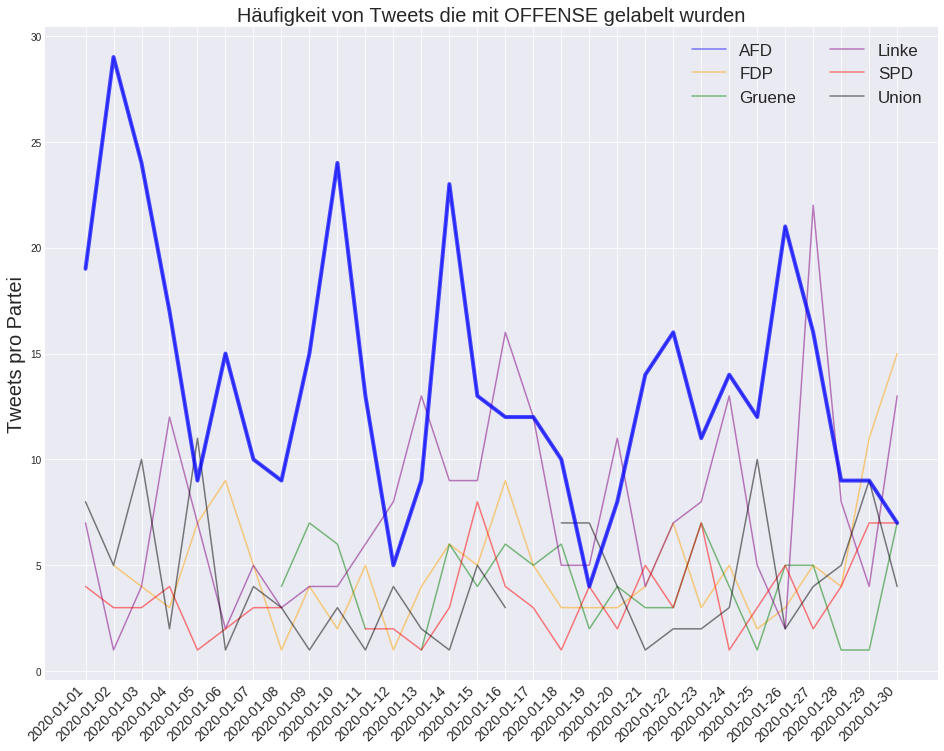

In [317]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot(111)

num=0
for column in partei_piv['full_text']:
    ax.plot(partei_piv.index, partei_piv['full_text'][column], color = my_palette[num], alpha=0.5, label = column)
    num+=1

ax.plot(partei_piv.index, partei_piv['full_text']['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)

ax.set_title('Häufigkeit von Tweets die mit OFFENSE gelabelt wurden', size = 20)
ylab = ax.set_ylabel('Tweets pro Partei', size = 20)
# = ax.set_xlabel('Datum', size = 20)
plt.legend(loc = 1, ncol = 2, fontsize = 17)

#x_tags
x_tags = plt.xticks(partei_piv.index, fontsize = 14, rotation = 45, ha = "right")


In [319]:
mdp_partei = sample_df[['user_party', 'week', 'user_screen_name', 'full_text', 'predict']]
mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv['full_text']
# partei_Piv = partei_piv['full_text']
# partei_Piv.groupby('week').sum()

user_party,AFD,FDP,Gruene,Linke,SPD,Union
week,,,,,,
20-w01,98,19,7,31,15,36
20-w02,91,27,19,32,12,17
20-w03,83,35,30,69,24,25
20-w04,96,27,27,50,26,24
20-w05,41,35,14,47,20,22


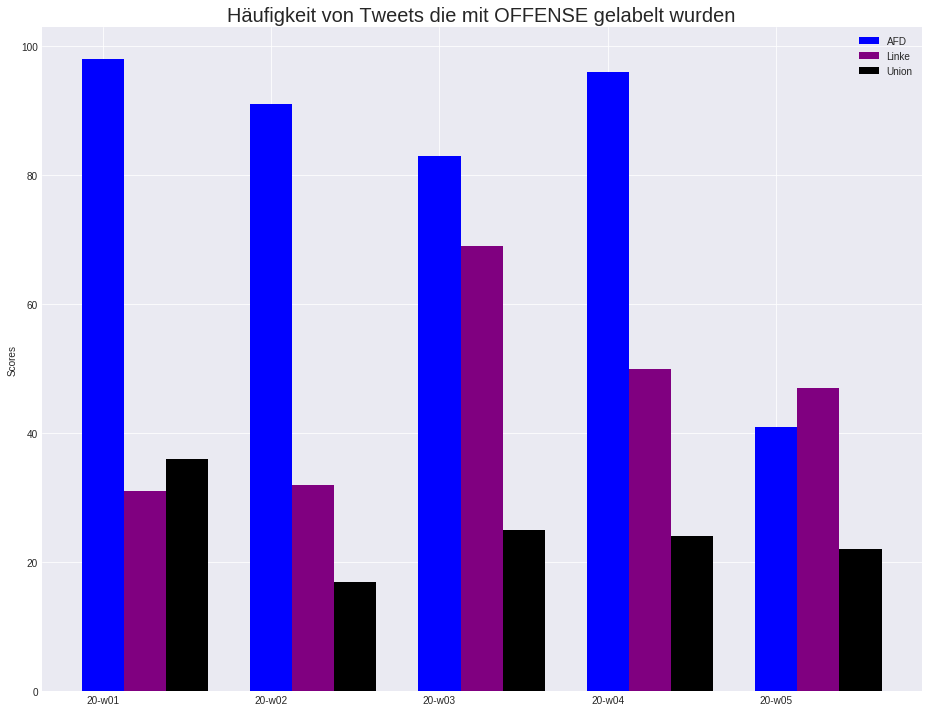

In [320]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig = plt.figure(figsize = (13, 10))
ax = fig.add_subplot(111)

r1 = np.arange(len(partei_piv['full_text'].index))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
# r4 = [x - width for x in r1]
# r5 = [x + width for x in r4]
# r6 = [x + width for x in r5]

# for column in partei_piv['full_text']:
#     ax.bar(partei_piv.index, partei_piv['full_text'][column], width, label=column)
ax.bar(r1, partei_piv['full_text']['AFD'], width, color = 'blue', label='AFD')
ax.bar(r2, partei_piv['full_text']['Linke'], width, color = 'purple', label='Linke')
ax.bar(r3, partei_piv['full_text']['Union'], width, color = 'black', label='Union')
# ax.bar(r3, partei_piv['full_text']['Gruene'], width, label='Gruene')
# ax.bar(r3, partei_piv['full_text']['Linke'], width, label='Linke')
# ax.bar(r3, partei_piv['full_text']['FDP'], width, label='FDP')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Häufigkeit von Tweets die mit OFFENSE gelabelt wurden', size = 20)
ax.set_xticks(r1)
ax.set_xticklabels(partei_piv['full_text'].index)
ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

In [322]:
mdp_partei = sample_df[['user_party', 'month', 'user_screen_name', 'full_text', 'predict']]
# mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['predict'], index = ['user_party'], aggfunc = np.count_nonzero)
partei_piv['full_text']
# partei_Piv = partei_piv['full_text']
# partei_Piv.groupby('week').sum()

predict,OFFENSE,OTHER
user_party,,
AFD,409,1214
FDP,143,2856
Gruene,97,2362
Linke,229,2169
SPD,97,2436
Union,124,2318


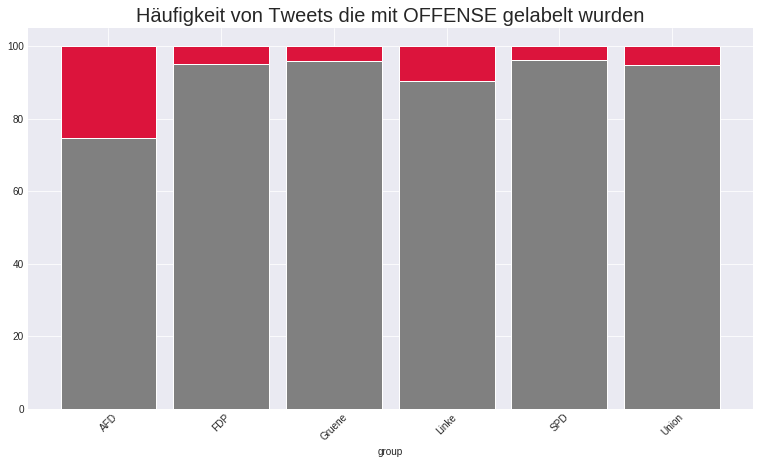

In [324]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# Data
# r = [0,1,2,3,4]
raw_data = {'greenBars': partei_piv['full_text']['OTHER'].values, 'orangeBars': partei_piv['full_text']['OFFENSE'].values}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.85
names = partei_piv['full_text'].index
fig = plt.figure(figsize = (13, 7))
ax = fig.add_subplot(111)

# Create green Bars
ax.bar(partei_piv['full_text'].index, greenBars, color='grey', edgecolor='white', width=barWidth)
# Create orange Bars
ax.bar(partei_piv['full_text'].index, orangeBars, bottom=greenBars, color='crimson', edgecolor='white', width=barWidth)

ax.set_title('Häufigkeit von Tweets die mit OFFENSE gelabelt wurden', size = 20)
# Custom x axis
plt.xticks(names, rotation =45)
plt.xlabel("group")
 
# Show graphic
plt.show()


In [343]:
# pd.set_option('display.max_rows', 0)
pd.set_option('display.max_rows', 500)

mdp_partei = sample_df[['user_party', 'week', 'user_screen_name', 'predict']]
# mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['predict'], index = ['user_party','user_screen_name'], aggfunc = np.count_nonzero)
partei_piv

week       
predict                     OFFENSE  OTHER
user_party user_screen_name               
AFD        AfDProtschka      8.0     46.0 
           Alice_Weidel      8.0     11.0 
           AndreasBleckMdB   9.0     22.0 
           Beatrix_vStorch   11.0    18.0 
           BerndBaumannAfD   3.0     3.0  
           Buettner_MdB      4.0     4.0  
           ChrWirthMdB      NaN      1.0  
           CorinnaMiazga     1.0     3.0  
           DirkSpaniel      NaN      10.0 
           DrFriesenMdB      2.0     24.0 
           DrHollnagel      NaN      4.0  
           DrMEspendiller    1.0     16.0 
           Dr_Rainer_Kraft   21.0    27.0 
           ElsnervonGronow   1.0     7.0  
           Frank_Pasemann    25.0    91.0 
           Frohnmaier_AfD   NaN      4.0  
           GottfriedCurio    7.0     6.0  
           GtzFrmming        11.0    75.0 
           HohmannMdb        2.0     10.0 
           Jacobi_AfD        1.0     16.0 
           Jan_Nolte_AfD     1.0     9.0  
           JensMaierAfD      7.0     17.0 
           JoanaCotar        19.0    63.0 
           Jochen_Haug      NaN      1.0  
           JuergenBraunAfD   29.0    68.0 
           KayGottschalk1    4.0     10.0 
           KestnerJens       6.0     10.0 
           Leif_Erik_Holm   NaN      3.0  
           M_HarderKuehnel  NaN      1.0  
           M_Reichardt_AfD   33.0    48.0 
           MalsackWinkeman   1.0     11.0 
           Marc_Jongen       1.0     1.0  
           Marcus_Buehl     NaN      13.0 
           Martin_Hess_AfD   10.0    20.0 
           Martin_Sichert    6.0     20.0 
           MdB_Lucassen     NaN      3.0  
           MdB_Mueller_AfD   1.0     3.0  
           NKleinwaechter    1.0     5.0  
           PeterBoehringer   1.0     5.0  
           PeterFelser       1.0     11.0 
           Pohl_MdB          1.0     3.0  
           R_Hartwig_AfD     1.0     19.0 
           Rene_Springer    NaN      7.0  
           Renner_AfD        1.0     8.0  
           S_Muenzenmaier    4.0     25.0 
           Schneider_AfD     4.0     13.0 
           StBrandner        89.0    212.0
           SteffenKotre     NaN      13.0 
           Thomas_Ehrhorn    1.0     3.0  
           Tino_Chrupalla    9.0     16.0 
           TobiasMPeterka    20.0    20.0 
           UdoHemmelgarn     27.0    67.0 
           Witt_Uwe          1.0     3.0  
           WolfgangWiehle    2.0     7.0  
           axelgehrke       NaN      1.0  
           h_weyel           5.0     27.0 
           mrosek1958        7.0     31.0 
           ulschzi           1.0     19.0 
FDP        AKulitz          NaN      2.0  
           BraFDP            4.0     47.0 
           BrittaDassler    NaN      1.0  
           Bubendorferfdp   NaN      2.0  
           Chr_Sauter       NaN      2.0  
           ChristophFDP      6.0     89.0 
           DFoest            12.0    100.0
           DanielaKluckert   3.0     46.0 
           DjirSarai        NaN      30.0 
           EUTheurer        NaN      14.0 
           G_UllrichFDP      2.0     25.0 
           GeroHocker        1.0     35.0 
           GydeJ             5.0     41.0 
           HartmutEbbing    NaN      18.0 
           HerbrandMarkus    2.0     26.0 
           HoffmannForest    5.0     95.0 
           HoubenReinhard   NaN      5.0  
           JBrandenburgFDP   4.0     40.0 
           JudithSkudelny   NaN      8.0  
           KatjaSuding       2.0     64.0 
           KatrinHelling    NaN      21.0 
           KonstantinKuhle   2.0     81.0 
           Lambsdorff       NaN      31.0 
           LindaTeuteberg    1.0     9.0  
           MAStrackZi        1.0     43.0 
           ManuelHoeferlin   3.0     17.0 
           MarcoBuschmann    9.0     359.0
           MarcusFaber      NaN      16.0 
           MdBKlein          1.0     13.0 
           NicoleWestig     NaN      4.0  
           OlliLuksic        15.0    161.0
           Otto_Fricke       2.0     68.0 
           PeterHeidtFDP    NaN 

In [346]:
sample_df[sample_df['user_screen_name'] == 'StBrandner']

,_id,created_at,id,full_text,is_quote_status,retweet_count,lang,created_at_datetime,user_id,user_name,...,user_followers_count,user_friends_count,user_created_at,partei,user_party,full_text_processed,predict,date,month,week
0,5e954d157973ce35734800bc,Tue Jan 28 12:12:49 +0000 2020,1222130406549487617,#Bargelderhalten!\n#AfD! https://t.co/biemIwvMKo,False,29,und,2020-01-28 12:12:49,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,BargelderhaltenAfD,OTHER,2020-01-28,20-01,20-w05
1,5e954d157973ce35734800bf,Tue Jan 28 10:19:44 +0000 2020,1222101948880637953,"+++Neue #Klartext! Hier runterladen+++\nhttps://t.co/JSG40sIJl3\nOder in meinen Büros in #Gera, #Erfurt, #Sömmerda abholen oder - bitte gegen frankieren Rückumschlag/ Angabe der gewünschten Anzahl - zusenden lassen. Danke an Alexandra!\n#Berlin #Bundestag #AfD #nurnochAfD #Brandner https://t.co/zF5YcWOtRj",False,20,de,2020-01-28 10:19:44,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,+++Neue Klartext Hier runterladen+++,OTHER,2020-01-28,20-01,20-w05
2,5e954d157973ce35734800c4,Mon Jan 27 15:46:21 +0000 2020,1221821755016339461,„entglast“... welcher Redakteur ist für sowas verantwortlich?🙄 https://t.co/XgRcVwHJxU,True,113,de,2020-01-27 15:46:21,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,entglast welcher Redakteur ist für sowas verantwortlich🙄,OTHER,2020-01-27,20-01,20-w05
3,5e954d157973ce35734800cf,Sun Jan 26 21:53:01 +0000 2020,1221551642845306882,#Obergrenze!🤔 https://t.co/ElPibDKHO9,True,8,und,2020-01-26 21:53:01,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Obergrenze🤔,OTHER,2020-01-26,20-01,20-w04
4,5e954d157973ce35734800d1,Sun Jan 26 21:33:12 +0000 2020,1221546656807751680,Hab ich schon vor ein paar Tagen gesagt!\n#AfDwirkt (sogar bei #BILD!) #nurnochAfD https://t.co/Y0MgYoDFaL,True,13,de,2020-01-26 21:33:12,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Hab ich schon vor ein paar Tagen gesagtAfDwirkt sogar bei BILD nurnochAfD,OTHER,2020-01-26,20-01,20-w04
5,5e954d157973ce35734800d9,Sun Jan 26 15:13:28 +0000 2020,1221451093735092230,@Frank_Pasemann @dunjahayali @AfDimBundestag @AfD Das hilft möglicherweise auch weiter... https://t.co/RIDN7MJkh5,False,8,de,2020-01-26 15:13:28,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Frank_Pasemann dunjahayali AfDimBundestag AfD Das hilft möglicherweise auch weiter,OTHER,2020-01-26,20-01,20-w04
6,5e954d157973ce35734800e9,Sat Jan 25 12:35:50 +0000 2020,1221049033915019264,"@CDUNds @rbrinkhaus @cducsubt „Renaissance“ heißt soviel wie Wiedergeburt. Da stellt sich die Frage, wer hat denn die #Wirtschaftspolitik sterben lassen und ist dann ausgerechnet derjenige ein guter Geburtshelfer? Wer regiert seit 15 bzw. über 70 Jahren? #cdu #csu #Altparteien #Altparteienlabern",False,2,de,2020-01-25 12:35:50,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,CDUNds rbrinkhaus cducsubt Renaissance heißt soviel wie Wiedergeburt Da stellt sich die Frage wer hat denn die Wirtschaftspolitik sterben lassen und ist dann ausgerechnet derjenige ein guter Geburtshelfer Wer regiert seit 15 bzw über 70 Jahren cdu csu Altparteien Altparteienlabern,OTHER,2020-01-25,20-01,20-w04
7,5e954d157973ce357348011c,Tue Jan 21 09:47:02 +0000 2020,1219557003124772869,#Buntland in 